# Laboratory Practice: Understanding calibration in CNNs

------------------------------------------------------
*Pablo Gradolph Oliva*

*Raquel Parajuá Delgado*

------------------------------------------------------

## 1. Introduction

In this project, we address calibration in convolutional neural networks (CNNs) applied to image classification. Despite the overwhelming success of CNNs in computer vision tasks, their ability to provide calibrated and reliable probability estimates remains an active area of research. The calibration of a model refers to its ability to produce probabilities representative of reality, i.e., a 75% probability assigned by a well-calibrated model should result in the correctness of the predicted event approximately 75% of the time.

Our analysis begins with training a CNN model, specifically Lenet5, from scratch to classify bird and cat images within the CIFAR10 ensemble. We then evaluate its calibration using the Reliability Plot and Expected Calibration Error (ECE), tools that allow us to visualize and quantify the discrepancy between predicted and observed probabilities.

To improve the calibration of our model, we apply Platt's scaling, a post-processing method that adjusts the output probabilities by modifying the logits before applying the softmax function. Studying the effect of the parameter 'a' in this process helps us understand how small adjustments can have a significant impact on model calibration.

Finally, we extend our research by applying these concepts to a larger pre-trained model by finely tuning its last classification layer.

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'  #To get figures with high quality!

import time
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Subset
from torch.utils.data.sampler import SubsetRandomSampler
from torchvision import datasets
from sklearn.calibration import calibration_curve

In [2]:
# Check if CUDA is available
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print("CUDA is not available. Training on CPU...")
else:
    print("CUDA is available. Training on GPU...")

CUDA is not available. Training on CPU...


## 2. Load and prepare data

In this step we will load the data from the CIFAR10 database. We will filter this data to obtain only images of birds and cats that correspond to labels 2 and 3 of the data. 

We will then create the data loaders for the training set, the validation set and prepare 5 different test sets that we will use during the project as we do not want these data to be used more than once by the model.

In [3]:
# number of subprocesses to use for data loading
num_workers = 0
# how many samples per batch to load
batch_size = 20
# percentage of training set to use as validation
valid_size = 0.2

# Data transform to convert data to a tensor and apply normalization
# augment train and validation dataset with RandomHorizontalFlip and RandomRotation
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(), # randomly flip and rotate
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

# choose the training and test datasets
train_data_full = datasets.CIFAR10('data', train=True,
                              download=True, transform=train_transform)
test_data_full = datasets.CIFAR10('data', train=False,
                             download=True, transform=test_transform)

# We filter to obtain only birds (2) and cats (3).
train_indices = [i for i, (_, label) in enumerate(train_data_full) if label in [2, 3]]
test_indices = [i for i, (_, label) in enumerate(test_data_full) if label in [2, 3]]

# Adjusts labels directly on complete datasets
for i in range(len(train_data_full.targets)):
    if train_data_full.targets[i] == 2:  # Bird
        train_data_full.targets[i] = 0
    elif train_data_full.targets[i] == 3:  # Cat
        train_data_full.targets[i] = 1

for i in range(len(test_data_full.targets)):
    if test_data_full.targets[i] == 2:  # Bird
        test_data_full.targets[i] = 0
    elif test_data_full.targets[i] == 3:  # Cat
        test_data_full.targets[i] = 1

for i in test_indices:
    if test_data_full.targets[i] == 2:  # Bird
        test_data_full.targets[i] = 0
    elif test_data_full.targets[i] == 3:  # Cat
        test_data_full.targets[i] = 1

# Create subsets of data with only birds and cats
train_data = Subset(train_data_full, train_indices)
test_data = Subset(test_data_full, test_indices)

# Obtain training indices that will be used for validation
num_train = len(train_data)
indices = list(range(num_train))
np.random.shuffle(indices)
split = int(np.floor(valid_size * num_train))
train_idx, valid_idx = indices[split:], indices[:split]

# Define samplers for obtaining training and validation batches
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

# Prepare data loaders (combine dataset and sampler)
train_loader = DataLoader(train_data, batch_size=batch_size, sampler=train_sampler, num_workers=num_workers)
valid_loader = DataLoader(train_data, batch_size=batch_size, sampler=valid_sampler, num_workers=num_workers)

# Prepare 5 test_loaders because we will need five of them during the project.
total_test = len(test_data)
subset_size = total_test // 5
leftover = total_test % 5
indices = np.random.permutation(total_test)
test_indices_splits = []
start = 0
for i in range(5):
    # Add an extra sample to the latest 'leftover' groups
    end = start + subset_size + (1 if i < leftover else 0)
    test_indices_splits.append(indices[start:end])
    start = end

test_subsets = [Subset(test_data, test_idx) for test_idx in test_indices_splits]
test_loaders = [DataLoader(test_subset, batch_size=batch_size, shuffle=False, num_workers=num_workers) for test_subset in test_subsets]

Files already downloaded and verified
Files already downloaded and verified


In [4]:
# Clases that we are going to work with in CIFAR database.
classes = ['bird', 'cat']

### 2.1. Visualize a Batch of Training Data

In [5]:
# Helper function to un-normalize and display an image
def imshow(img):
    img = img / 2 + 0.5
    plt.imshow(np.transpose(img, (1, 2, 0)))

In [6]:
# Obtain one batch of training images
dataiter = iter(train_loader)
images, labels = next(dataiter)
images = images.numpy()
images.shape # (number of examples: 20, number of channels: 3, pixel sizes: 32x32)

(20, 3, 32, 32)

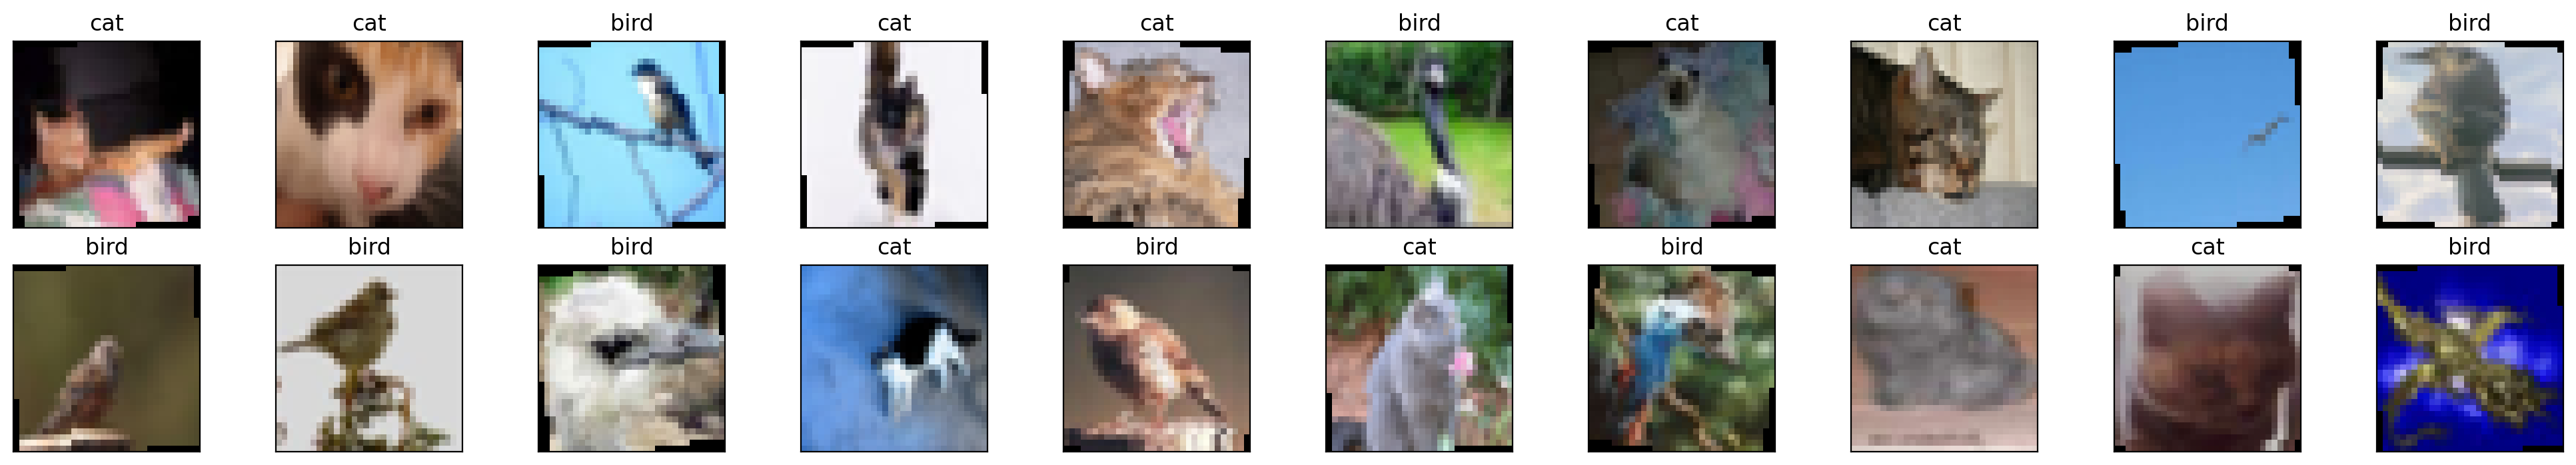

In [7]:
# Plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, int(20/2), idx+1, xticks=[], yticks=[])
    imshow(images[idx])
    ax.set_title(classes[labels[idx]])

### 2.2. View an Image in More Detail

Here, we look at the normalized red, green, and blue (RGB) color channels as three separate, grayscale intensity images.

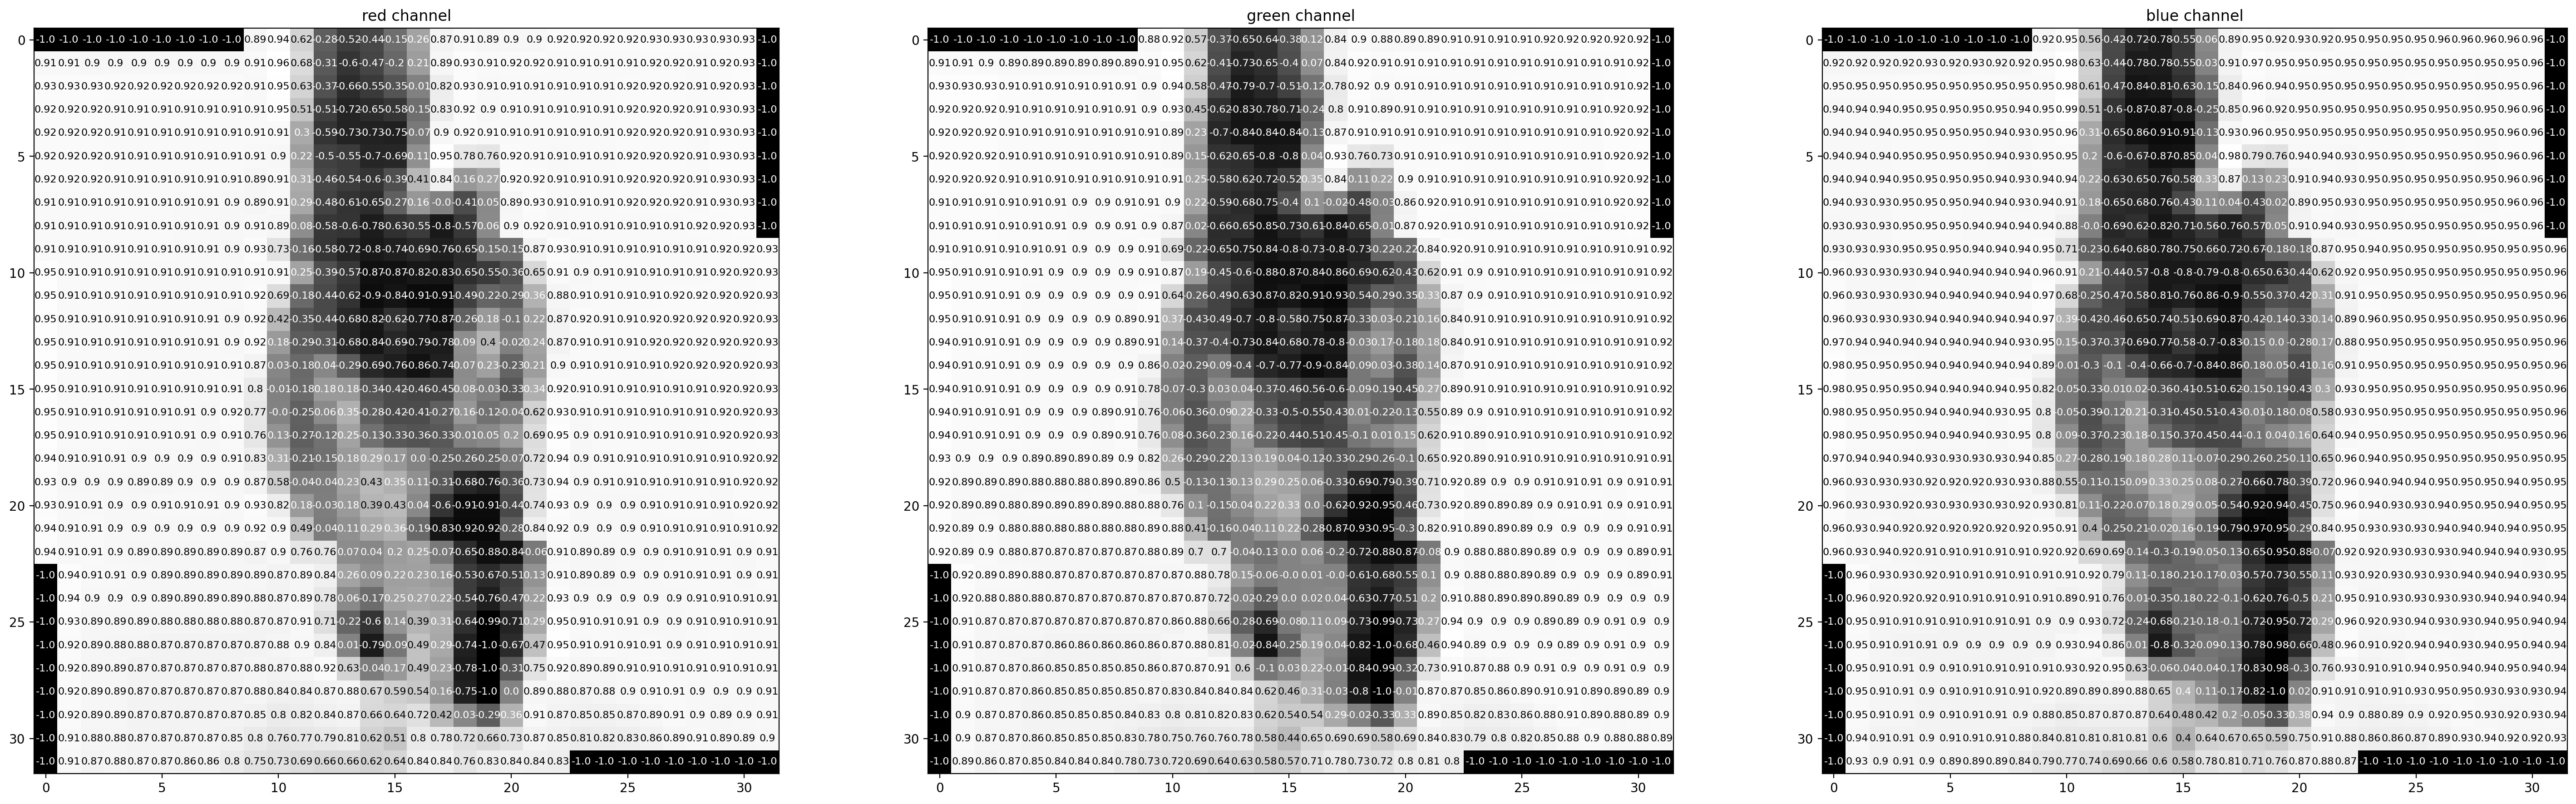

In [9]:
rgb_img = np.squeeze(images[3])
channels = ['red channel', 'green channel', 'blue channel']

fig = plt.figure(figsize = (36, 36)) 
for idx in np.arange(rgb_img.shape[0]):
    ax = fig.add_subplot(1, 3, idx + 1)
    img = rgb_img[idx]
    ax.imshow(img, cmap='gray')
    ax.set_title(channels[idx])
    width, height = img.shape
    thresh = img.max()/2.5
    for x in range(width):
        for y in range(height):
            val = round(img[x][y],2) if img[x][y] !=0 else 0
            ax.annotate(str(val), xy=(y,x),
                    horizontalalignment='center',
                    verticalalignment='center', size=8,
                    color='white' if img[x][y]<thresh else 'black')

## 3. Define the Network Architecture

In this section of the project, we define the architecture of our convolutional neural network (CNN), specifically a variant of the Lenet5 model adapted to our binary classification problem between birds and cats on the CIFAR10 dataset.

The network is composed of three convolutional layers. Each convolutional layer applies a set of filters to the input, followed by the ReLU activation function and a max pooling operation to reduce the spatial dimensionality while preserving the most important information.

After the convolutional and pooling layers, the network flattens the output to form a feature vector, which then passes through two linear layers (also known as fully connected or dense layers). These layers are used to perform classification based on the extracted features, mapping the feature vector to the probabilities of belonging to each of the two classes. A dropout layer is introduced before each linear layer to reduce the risk of overfitting by regularization, randomly deactivating a subset of neurons during training.

The particularity of this model is the inclusion of an optional return_logits argument in the forward function. This mechanism allows the network to return the logits, i.e. the outputs of the network before applying the softmax function, which is crucial for the subsequent application of Platt's scaling for probability calibration.

In [10]:
class Lenet5(nn.Module):
    def __init__(self,dimx,nlabels): #Nlabels will be 2 in our case
        super(Lenet5, self).__init__()

        # Convolutional layer (sees 32x32x3 image tensor)
        self.conv1 = nn.Conv2d(3, 16, 3, padding=1)
        # Convolutional layer (sees 16x16x16 tensor)
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1)
        # Convolutional layer (sees 8x8x32 tensor)
        self.conv3 = nn.Conv2d(32, 64, 3, padding=1)
        # Max pooling layer
        self.pool = nn.MaxPool2d(2, 2)
        # Linear layer (64 * 4 * 4 -> 500)
        self.fc1 = nn.Linear(64 * 4 * 4, 500)
        # Linear layer (500 -> nlabels)
        self.fc2 = nn.Linear(500, nlabels)
        # Dropout layer (p=0.2)
        self.dropout = nn.Dropout(0.2)

    def forward(self, x, return_logits=False): # return_logits will be used for Platt's scalling.
        # add sequence of convolutional and max pooling layers
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        # Flatten image input
        x = x.view(-1, 64 * 4 * 4)
        # Add dropout layer
        x = self.dropout(x)
        # Add 1st hidden layer, with relu activation function
        x = F.relu(self.fc1(x))
        # Add dropout layer
        x = self.dropout(x)
        # Add 2nd hidden layer.
        x = self.fc2(x)
        if return_logits:
            return x
        x = F.log_softmax(x, dim=1)
        return x

The Lenet5_extended class is an extension of the previously defined Lenet5 model, adapted to provide a more complete structure that includes not only the architecture definition, but also the implementation of the training and evaluation cycle of the model.

The trainloop function encapsulates the complete training cycle, alternating between training and validation phases. A highlight is the ability to save the state of the model when a reduction in validation loss is achieved, facilitating the recovery of the best trained model.

Finally, the eval_performance function allows evaluating the model performance on any provided dataset, returning the classification accuracy.

In [11]:
class Lenet5_extended(Lenet5):
    def __init__(self,dimx,nlabels,epochs=30,lr=0.001):
        super().__init__(dimx,nlabels)

        self.lr = lr #Learning Rate
        self.optim = optim.Adam(self.parameters(), self.lr)
        self.epochs = epochs
        self.criterion = nn.NLLLoss()

        # A list to store the loss evolution along training
        self.loss_during_training = []
        self.valid_loss_during_training = []
        self.valid_loss_min = [np.Inf] # Track change in validation loss

    def trainloop(self,trainloader,validloader):
        # Set the model to training mode
        self.train()

        # Optimization Loop
        for e in range(int(self.epochs)):
            start_time = time.time()
            # Random data permutation at each epoch
            running_loss = 0.

            for images, labels in trainloader:
                if train_on_gpu:
                  images, labels = images.cuda(), labels.cuda()  # Move to GPU

                self.optim.zero_grad()  #TO RESET GRADIENTS!
                out = self.forward(images)
                loss = self.criterion(out,labels)
                running_loss += loss.item()
                loss.backward()
                self.optim.step()

            self.loss_during_training.append(running_loss/len(trainloader))

            # Validation Loss
            self.eval()
            # Turn off gradients for validation, saves memory and computations
            with torch.no_grad():
                running_loss = 0.

                for images,labels in validloader:
                    out = self.forward(images)
                    loss = self.criterion(out,labels)
                    running_loss += loss.item()

                self.valid_loss_during_training.append(running_loss/len(validloader))

            if(e % 1 == 0): # Every epoch
                print("Epoch %d. Training loss: %f, Validation loss: %f, Time per epoch: %f seconds"
                      %(e+1,self.loss_during_training[-1],self.valid_loss_during_training[-1],
                       (time.time() - start_time)))
                
                # Save model if validation loss has decreased
                if self.valid_loss_during_training[-1] <= self.valid_loss_min[-1]:
                    print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
                    self.valid_loss_min[-1],
                    self.valid_loss_during_training[-1]))
                    torch.save(self.state_dict(), 'model_cifar.pt')
                    self.valid_loss_min[-1] = self.valid_loss_during_training[-1]

            # Set back to train mode
            self.train()

    def eval_performance(self,dataloader):
        # Set the model to evaluation mode
        self.eval()

        accuracy = 0

        # Turn off gradients for validation, saves memory and computations
        with torch.no_grad():
            for images, labels in dataloader:
                if train_on_gpu:
                  images, labels = images.cuda(), labels.cuda()  # Move to GPU
                probs = self.forward(images)
                top_p, top_class = probs.topk(1, dim=1)
                equals = (top_class == labels.view(images.shape[0], 1))
                accuracy += torch.mean(equals.type_as(probs))

            return accuracy/len(dataloader)

## 4. Model training

In [12]:
model = Lenet5_extended(dimx=32,nlabels=2,epochs=20,lr=1e-3)
if train_on_gpu:
    model.cuda()
model.trainloop(train_loader,valid_loader)

Epoch 1. Training loss: 0.570821, Validation loss: 0.492872, Time per epoch: 15.380956 seconds
Validation loss decreased (inf --> 0.492872).  Saving model ...
Epoch 2. Training loss: 0.479891, Validation loss: 0.460434, Time per epoch: 19.620236 seconds
Validation loss decreased (0.492872 --> 0.460434).  Saving model ...
Epoch 3. Training loss: 0.447377, Validation loss: 0.404040, Time per epoch: 17.251475 seconds
Validation loss decreased (0.460434 --> 0.404040).  Saving model ...
Epoch 4. Training loss: 0.416342, Validation loss: 0.426758, Time per epoch: 17.095961 seconds
Epoch 5. Training loss: 0.399856, Validation loss: 0.379728, Time per epoch: 17.365387 seconds
Validation loss decreased (0.404040 --> 0.379728).  Saving model ...
Epoch 6. Training loss: 0.382450, Validation loss: 0.357640, Time per epoch: 23.307694 seconds
Validation loss decreased (0.379728 --> 0.357640).  Saving model ...
Epoch 7. Training loss: 0.364004, Validation loss: 0.351268, Time per epoch: 20.575310 sec

###  4.1. Load the Model with the Lowest Validation Loss

In [28]:
model.load_state_dict(torch.load('model_cifar.pt'))

<All keys matched successfully>

Here we plot the loss curves, providing a clear view of how the model learns and fits the data over epochs. The line representing training loss shows how the model improves its ability to predict the data it is trained on, while the validation loss line indicates how the model generalizes to unseen data. 

tensor(0.9160)
tensor(0.8715)


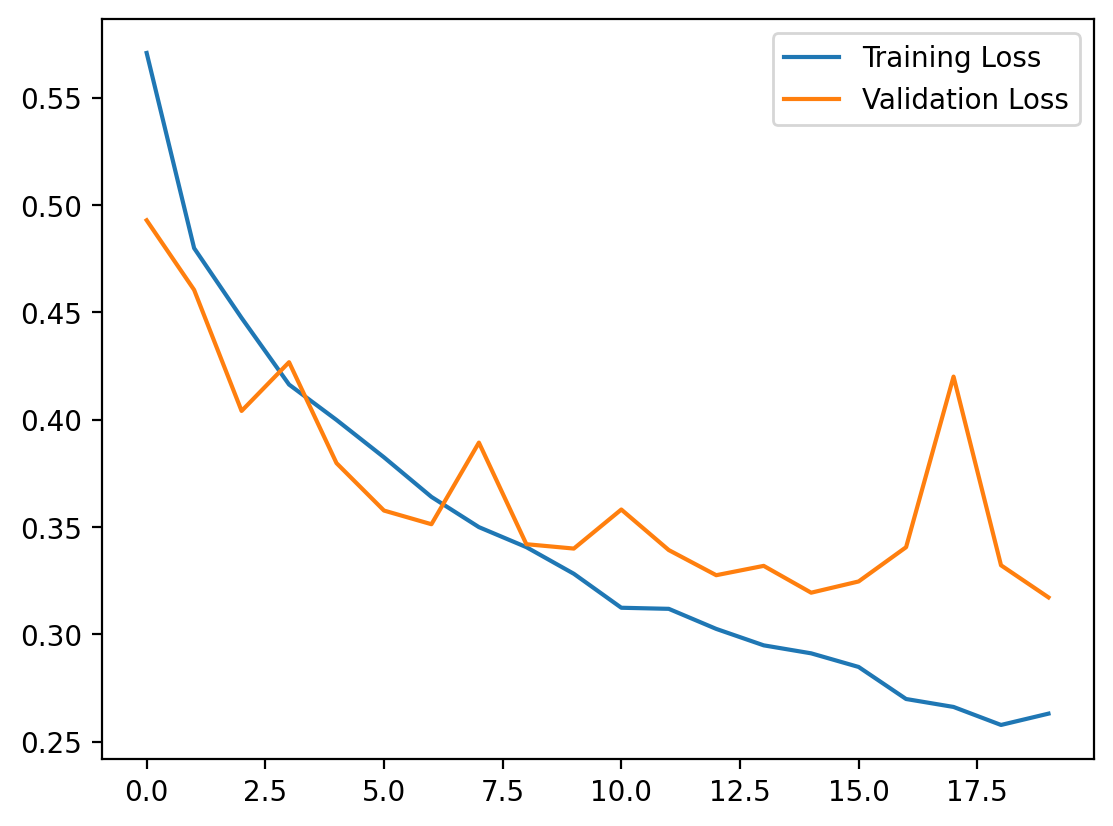

In [29]:
plt.plot(model.loss_during_training,label='Training Loss')
plt.plot(model.valid_loss_during_training,label='Validation Loss')
plt.legend()

print(model.eval_performance(train_loader))
print(model.eval_performance(valid_loader))

## 5. Test our Model

In this code snippet we evaluate the performance of our machine learning model on a test set (we use the first one created), focusing on loss and accuracy per class. At the end of training, it is critical to verify how the model behaves on data not seen during training to understand its generalizability.

In [30]:
# Track test loss
test_loss = 0.0
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

model.eval()
# Iterate over test data
for data, target in test_loaders[0]:
    # Move tensors to GPU if CUDA is available
    if train_on_gpu:
        data, target = data.cuda(), target.cuda()

    output = model(data)
    loss = model.criterion(output, target)
    test_loss += loss.item()*data.size(0)
    # Convert output probabilities to predicted class
    _, pred = torch.max(output, 1)    
    # Compare predictions to true label
    correct_tensor = pred.eq(target.data.view_as(pred))
    correct = np.squeeze(correct_tensor.numpy()) if not train_on_gpu else np.squeeze(correct_tensor.cpu().numpy())
    # Calculate test accuracy for each object class
    for i in range(batch_size):
        label = target.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1

# Average test loss
test_loss = test_loss/len(test_loaders[0].dataset)
print('Test Loss: {:.6f}\n'.format(test_loss))

for i in range(2):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            classes[i], 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))

Test Loss: 0.264944

Test Accuracy of  bird: 84% (158/188)
Test Accuracy of   cat: 91% (195/212)

Test Accuracy (Overall): 88% (353/400)


Now let's visualize graphically how our model predicts to which class an image belongs. In this code fragment the probabilities are stored with their true label to show the probability that the model has calculated that the image belongs to the class to which it truly belongs.

In [31]:
# Variables to store probabilities and labels
probs_list = []
labels_list = []

# Iterate on the test set (We use the second test set)
model.eval()
for images, labels in test_loaders[1]:
    # If CUDA is available, move the data to the GPU.
    if train_on_gpu:
        images, labels = images.cuda(), labels.cuda()
    # Calculating model output
    output = model(images, return_logits=True)
    # Calculate probabilities using softmax
    probs = F.softmax(output, dim=1)
    # Saving probabilities and labels
    probs_list.append(probs.detach().cpu().numpy())
    labels_list.append(labels.detach().cpu().numpy())

# Concatenate all probabilities and labels in numpy arrays
probs = np.concatenate(probs_list, axis=0)
labels = np.concatenate(labels_list, axis=0)

# Show some images with probabilities
test_data = test_subsets[1]
indices = np.random.choice(len(test_data), 20, replace=False)
selected_images = [test_data[i][0] for i in indices]
selected_probs = probs[indices]
selected_labels = labels[indices]

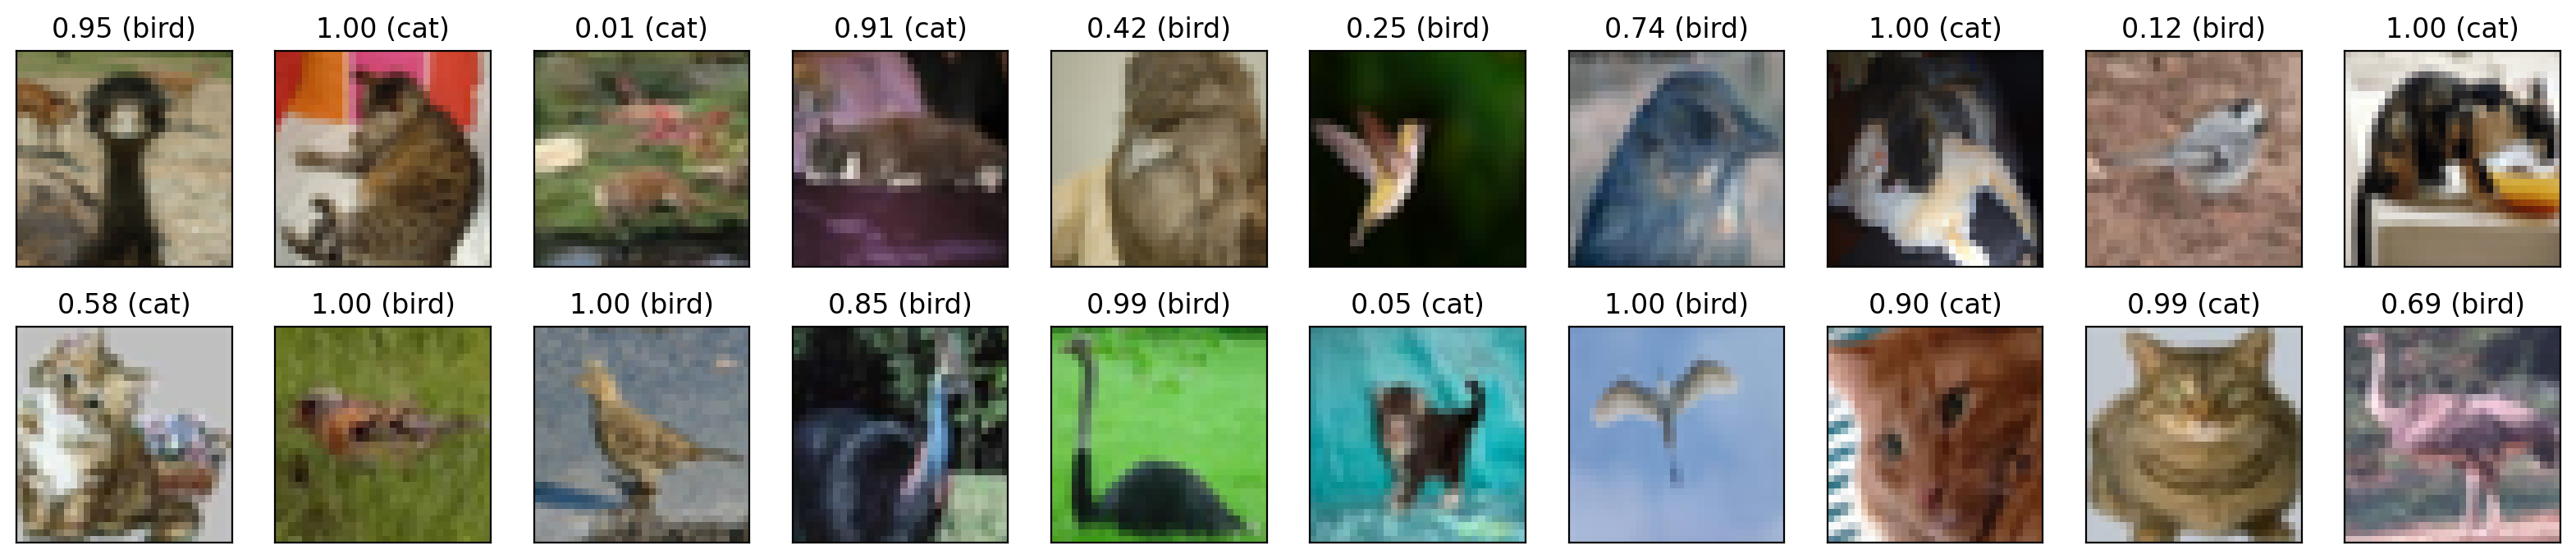

In [32]:
# Show images and the probability predicted by the model of belonging to the class it actually belongs to.
plt.figure(figsize=(20, 4))
for idx in range(20):
    ax = plt.subplot(2, 10, idx+1, xticks=[], yticks=[])
    imshow(selected_images[idx])
    ax.set_title(f"{selected_probs[idx][selected_labels[idx]]:.2f} ({'cat' if selected_labels[idx]==1 else 'bird'})")
plt.show()

## 6. Reliability Diagram and Expected Calibration Error (ECE)

We are faced with a binary classification problem, where we have two classes, which we will label as positive (1) and negative (0) for this explanation. For each prediction made by our model, we will have a set of probabilities for each class. Since it is a binary problem, the sum of the probabilities of both classes must be 1.

In calculating the reliability diagram and the ECE, what we evaluate is how well calibrated the predicted probabilities of our model are compared to the true labels. If the probability of the positive class is well calibrated, by extension, the probability of the negative class will also be well calibrated, since the two are intrinsically related. In other words, a good calibration in the predictions of the positive class will be reflected in the negative class due to their complementary relationship.

Therefore, in a binary classification problem, the analysis of the calibration of one class is sufficient to understand the calibration of the model as a whole, since you cannot have one class well calibrated and the other not in this binary context.

In [33]:
model.eval()
probs_list = []
labels_list = []

# Function to calculate the ECE using the calibration curve technique
def calculate_ece_with_calibration_curve(probs, labels, n_bins=10):
    fraction_of_positives, mean_predicted_value = calibration_curve(labels, probs, n_bins=n_bins, strategy='uniform')
    ece = np.abs(fraction_of_positives - mean_predicted_value).mean()
    return ece

# Iterate over test data to compile probabilities and true labels.
# We use the third set of test data.
with torch.no_grad():
    for data, target in test_loaders[2]:
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
        output = model(data, return_logits=True)
        # We use softmax to convert logits into probabilities.
        probabilities = F.softmax(output, dim=1)
        # Here we are assuming that the model has 2 classes and we take the second column, i.e. the class 'cat'.
        cat_probs = probabilities[:, 1]
        probs_list.extend(cat_probs.cpu().numpy())
        labels_list.extend(target.cpu().numpy())

# Convert lists to numpy arrays for use with scikit-learn
probs = np.array(probs_list)
labels = np.array(labels_list)

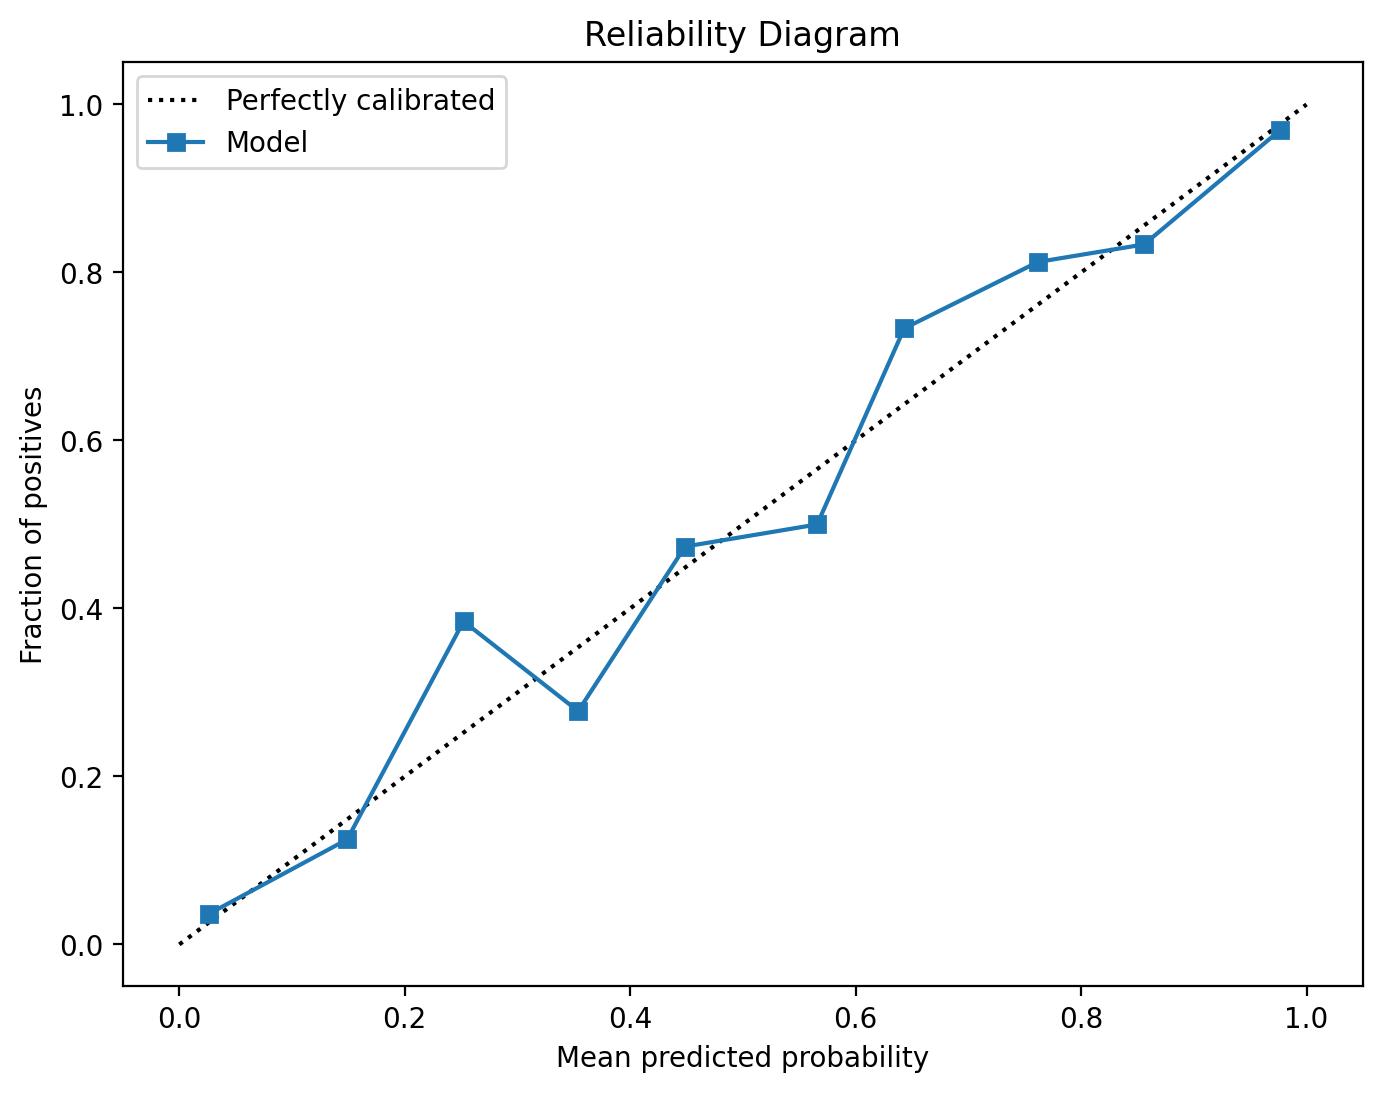

ECE: 0.050398


In [34]:
# Calculating the calibration curve and ECE
prob_true, prob_pred = calibration_curve(labels, probs, n_bins=10)
ece_before_scaling = calculate_ece_with_calibration_curve(probs, labels, n_bins=10)

# Mostrar el diagrama de fiabilidad
plt.figure(figsize=(8, 6))
plt.plot([0, 1], [0, 1], 'k:', label='Perfectly calibrated')
plt.plot(prob_pred, prob_true, 's-', label='Model')
plt.xlabel('Mean predicted probability')
plt.ylabel('Fraction of positives')
plt.title('Reliability Diagram')
plt.legend()
plt.show()

print(f'ECE: {ece_before_scaling:.6f}')

- Dotted line (Perfectly calibrated): Represents perfect calibration. In a perfectly calibrated model, the predicted probability matches the true frequency. For example, if a model predicts a class with a 75% probability, then we would expect that class to be true 75% of the time.

- Solid Line (Model): Shows the calibration performance of our model. Each point on the line represents a bin of predicted probabilities. For example, the first dot on the left might represent all the predictions where our model was 10% sure that the image was a cat. If that point is above the dotted line, it means the model is underestimating the probability; if it is below, it is overestimating.

- ECE (Expected Calibration Error): This is a measure that summarizes the difference between the predicted and observed probabilities. A low ECE means that our model is generally well calibrated. An ECE of 0.050398 like the one we have indicates that, on average, the difference between the predicted and observed probability is about 5%.

## 7. Platt's scalling

Platt's scaling is a post-processing technique that adjusts the outputs of a model (usually logits before the softmax function) using logistic regression. The objective is to find a "temperature" factor to "smooth" the model's predicted probabilities. This factor adjusts the scale of the logits before applying softmax to obtain the new fitted probability.

This process involves finding the temperature parameter 'a' that best calibrates our model and then applying this setting to the logits before running them through the softmax function to obtain the calibrated probabilities.

First we will collect the logits, which are the direct outputs of the neural network before the application of the softmax activation function. By evaluating on a test set, and storing these along with the true labels, sets the stage for the evaluation of model calibration. Collecting logits is a crucial preliminary step that facilitates the subsequent application of calibration techniques and measurement of the model's confidence in its predictions.

In [35]:
model.eval()
valid_logits_list = []
test_logits_list = []
valid_labels_list = []
test_labels_list = []

with torch.no_grad():
    # For the test set
    for data, target in test_loaders[2]:
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
        logits = model(data, return_logits=True)
        test_logits_list.append(logits.cpu().numpy())
        test_labels_list.append(target.cpu().numpy())

# Convert lists to numpy arrays
test_logits = np.concatenate(test_logits_list, axis=0)
test_labels = np.concatenate(test_labels_list, axis=0)

Secondly, we are going to apply Platt's scaling for a parameter a=1, which should not change the calculated ECE, later we will do a study of how the ECE varies according to the value of this parameter 'a' considered as the inverse of the temperature 'T' and we will stay with the best possible value of 'a' to see how the model calibration varies.

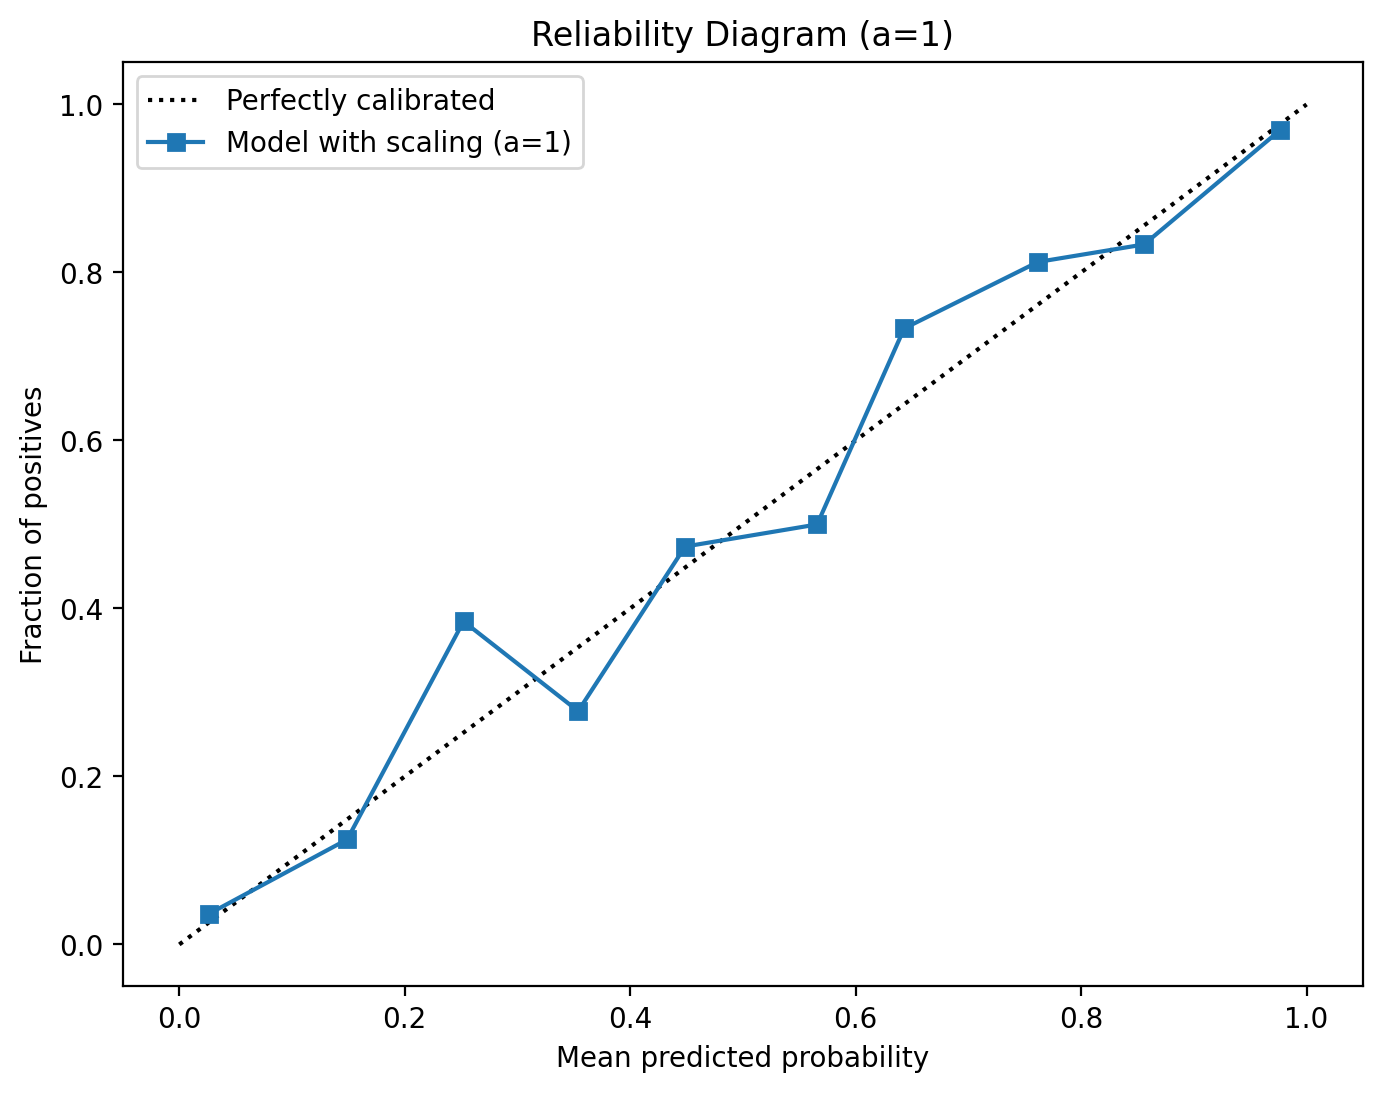

ECE with scaling (a=1): 0.050398


In [36]:
from scipy.special import softmax

# Calculate probabilities using softmax without logit scaling
probs_scaling = softmax(test_logits, axis=1)

# Calculate ECE and draw the reliability diagram for a=1
ece_after_scaling = calculate_ece_with_calibration_curve(probs_scaling[:, 1], test_labels, n_bins=10)
fraction_of_positives, mean_predicted_value = calibration_curve(test_labels, probs_scaling[:,1], n_bins=10)

plt.figure(figsize=(8, 6))
plt.plot([0, 1], [0, 1], 'k:', label='Perfectly calibrated')
plt.plot(mean_predicted_value, fraction_of_positives, 's-', label='Model with scaling (a=1)')
plt.xlabel('Mean predicted probability')
plt.ylabel('Fraction of positives')
plt.title('Reliability Diagram (a=1)')
plt.legend()
plt.show()

print(f'ECE with scaling (a=1): {ece_after_scaling:.6f}')

### 7.1. Study of parameter a

We have seen that the ECE does not change for a=1, as is logical since we do not change the logits. Now we are going to study how the ECE changes with respect to the value of a for a series of values ​​of a between 0 and 5 (negative values ​​do not make sense).

Then we will keep the best value of 'a' found to see the new diagram and the ECE for this value

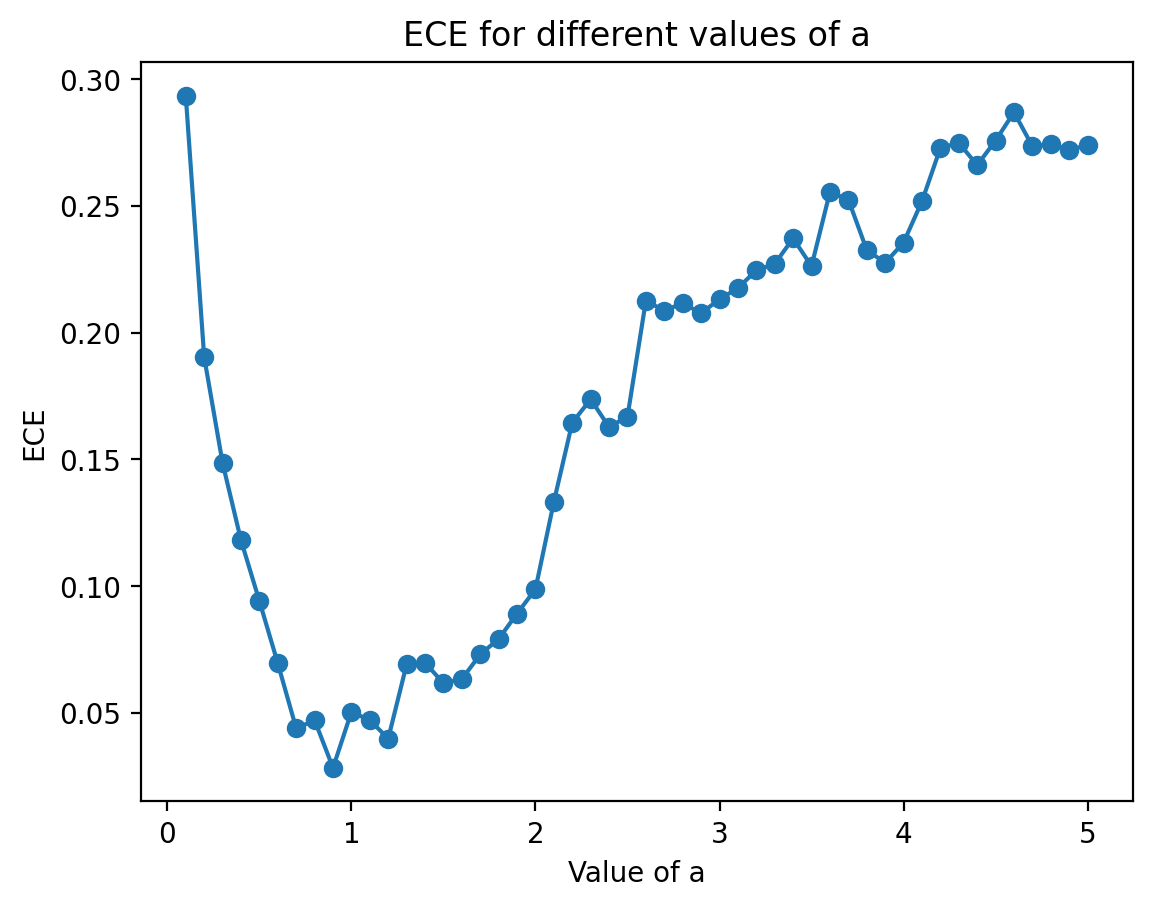

Best a: 0.9 with ECE: 0.028339


In [37]:
a_values = np.linspace(0.1, 5.0, 50)
ece_values = []

for a in a_values:
    scaled_logits = test_logits * a  # We use multiplication because a is the inverse of T
    
    # Calculate scaled probabilities using softmax
    scaled_probs = softmax(scaled_logits, axis=1)
    
    # Calculate the ECE for scaled probabilities
    ece_after_scaling = calculate_ece_with_calibration_curve(scaled_probs[:, 1], test_labels, n_bins=10)
    ece_values.append(ece_after_scaling)

# Plot the ECE based on the values ​​of a
plt.plot(a_values, ece_values, 'o-')
plt.xlabel('Value of a')
plt.ylabel('ECE')
plt.title('ECE for different values of a')
plt.show()

# Identify the value of a with the lowest ECE
min_ece_index = np.argmin(ece_values)
best_a = a_values[min_ece_index]
print(f"Best a: {best_a} with ECE: {ece_values[min_ece_index]:.6f}")

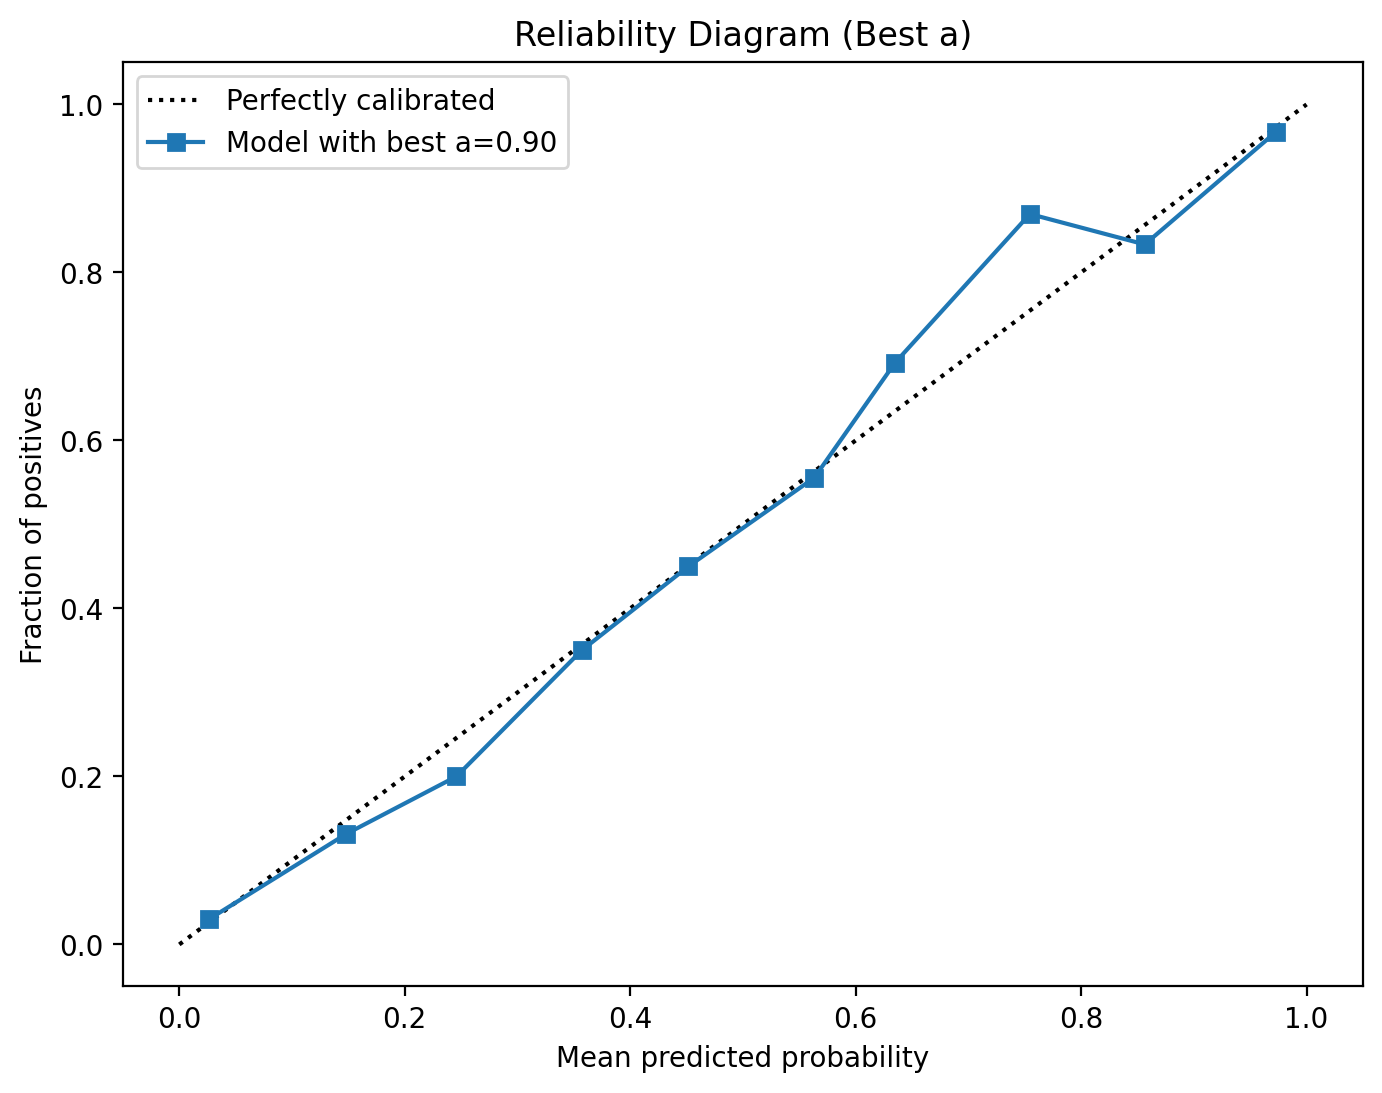

ECE with best a (a=0.90): 0.028339


In [38]:
# Scale the logits by the best value of a found
scaled_logits_best_a = test_logits * best_a

# Calculate scaled probabilities using softmax
scaled_probs_best_a = softmax(scaled_logits_best_a, axis=1)

# Calculate ECE and draw the reliability diagram for the best a
ece_best_a = calculate_ece_with_calibration_curve(scaled_probs_best_a[:, 1], test_labels, n_bins=10)
fraction_of_positives_best_a, mean_predicted_value_best_a = calibration_curve(test_labels, scaled_probs_best_a[:,1], n_bins=10)

plt.figure(figsize=(8, 6))
plt.plot([0, 1], [0, 1], 'k:', label='Perfectly calibrated')
plt.plot(mean_predicted_value_best_a, fraction_of_positives_best_a, 's-', label=f'Model with best a={best_a:.2f}')
plt.xlabel('Mean predicted probability')
plt.ylabel('Fraction of positives')
plt.title('Reliability Diagram (Best a)')
plt.legend()
plt.show()

print(f'ECE with best a (a={best_a:.2f}): {ece_best_a:.6f}')

## 8. Save the best value of a to use the best calibrated model.

In this last step we are simply going to use our model but adjusting with the best parameter of 'a' found to ensure that it is better calibrated. As before we will represent a series of data from the last test set

In [39]:
with open('best_a_value.txt', 'w') as f:
    f.write(str(best_a))

model.load_state_dict(torch.load('model_cifar.pt'))

<All keys matched successfully>

Here is the simple way the model would be used using the parameter 'a' calculated as the best to make predictions.

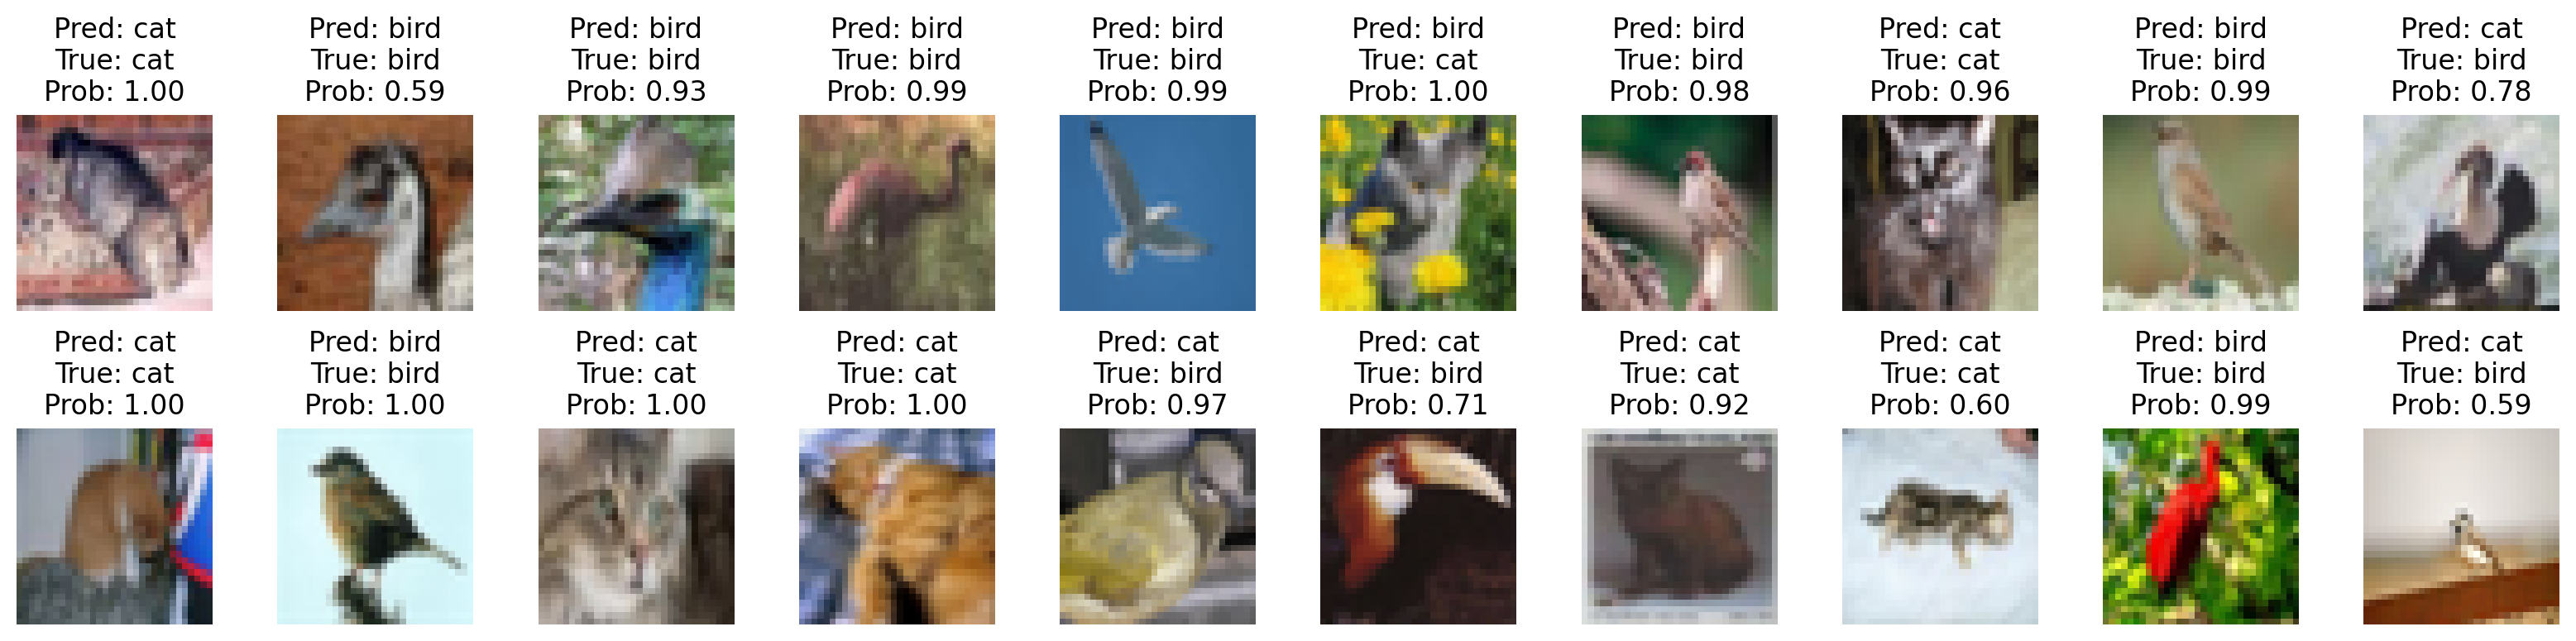

In [40]:
with open('best_a_value.txt', 'r') as f:
    best_a = float(f.read())

# Select a small set of images to demonstrate the prediction
dataiter = iter(test_loaders[4])
images, labels = next(dataiter)

# Move model and images to GPU if available
if torch.cuda.is_available():
    images = images.cuda()
    model.cuda()

model.eval()
with torch.no_grad():
    logits = model(images, return_logits=True)
    logits_scaled = logits.cpu().numpy() * best_a  # Apply the calibration factor 'a' to the logits
    probs = softmax(logits_scaled, axis=1)  # Calculate calibrated probabilities using softmax

# Show images and their calibrated probabilities
plt.figure(figsize=(20, 4))
plt.subplots_adjust(hspace=0.6)
for i in range(len(images)):
    ax = plt.subplot(2, len(images)//2, i+1)
    imshow(images[i].cpu())
    predicted_class = np.argmax(probs[i])
    true_class = labels[i].item()
    ax.set_title(f"Pred: {classes[predicted_class]}\nTrue: {classes[true_class]}\nProb: {probs[i][predicted_class]:.2f}")
    plt.axis('off')
plt.show()